# FEATURE ENGINEERING (TASK 2)

## COLUMN REDEFINITION


### Name
The first column to be redefined is the name, in the base dataset the conversion from the url is counterintuitive and include ambiguous informations.
We have to check if exists name with more than 3 entry.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from os import path

df3 = pd.read_csv(path.join('..','dataset', 'cyclists_cleaned.csv'))

colonna = df3['name']

conteggio_parole = colonna.apply(lambda x: len(str(x).split()))

distribuzione = conteggio_parole.value_counts().sort_index(ascending=False)

print(distribuzione)

name
6       1
5      10
4     116
3     757
2    5250
Name: count, dtype: int64


In this case we have to check if there are name with more surname.

In [2]:
colonna = df3['name']

conteggio_parole = colonna.apply(lambda x: len(str(x).split("  ")))

distribuzione = conteggio_parole.value_counts().sort_index(ascending=False)

print(distribuzione)

name
3       1
2    5750
1     383
Name: count, dtype: int64


We can see that we have name without surname and names with two surnames.

In [3]:
conteggio_parole = colonna.apply(lambda x: len(str(x).split("  ")))

dataset_3_parole = df3[conteggio_parole == 3]
dataset_1_parola = df3[conteggio_parole == 1]

dataset_3_parole.head()


,_url,name,birth_year,weight,height,nationality
1009,jose-luis-roldan,Jose Luis Roldán,1985,61.0,175,Spain


In [4]:
df3.at[1009, 'name'] = 'Jose Luis  Roldán'

We infer the convention that the last word in the name is the surname so we standardize the format (name-whitespace for each second name-surname)

In [5]:
def add_whitespace(string):
    parole = string.split("  ")
    if len(parole) == 1:
        wordsplitted = string.split(' ')
        wordsplitted[-1] = ' ' + parole[-1] 
        return ' '.join(wordsplitted)
    return string

df3['name'] = colonna.apply(add_whitespace)

In [6]:
colonna = df3['name']

conteggio_parole = colonna.apply(lambda x: len(str(x).split("  ")))

distribuzione = conteggio_parole.value_counts().sort_index(ascending=False)

print(distribuzione)


name
2    6134
Name: count, dtype: int64


Now that we have standardized name format we can check the url, remembering the previously convention, surname are formed with one word so all the strings before the last "-" are part of the name. In the wrong values section we have seen cases where misses the last word of the surname so we can apply 2 strategies:
- Where the url has more entry than the name we put the new part in the name in a position based on the url position. So if we find name-surname-(another string) and the another string is missing in the name part that will be part of the surname, the same for the second name
- Where the name has more entry than the url we fill the url adding "-" at the right point

Adding information to name from the url.


In [7]:
import re, unicodedata

def normalize_text(testo):
    testo_normale = unicodedata.normalize('NFD', testo)
    testo_senza_accenti = ''.join([c for c in testo_normale if unicodedata.category(c) != 'Mn'])
    testo_finale = re.sub(r'[^a-zA-Z0-9\s]', '', testo_senza_accenti)
    return testo_finale


def fix_name(stringurl, stringname):

    stringfixed = stringurl.replace('-',' ').lower()
    stringfixed = re.sub(r'\d+', '', stringfixed)
    stringfixed = stringfixed.title()
    vettoreurl = stringfixed.split()
    
    stringnamefixed = normalize_text(stringname)
    vettorename = re.split(r'\s+', stringnamefixed)
    # Index of the double space in the name
    match = re.search(r'  ', stringname)
    
    if len(vettoreurl) == len(vettorename):
        return stringname
    length = 0

    for indiceurl in range(len(vettoreurl)):
        length += len(vettoreurl[indiceurl])
        if vettoreurl[indiceurl] not in vettorename:
            vettorename.insert(indiceurl, vettoreurl[indiceurl])
            # Second name found, doble space position is changed
            if length < match:
                match = match + len(vettoreurl[indiceurl])
        length = length+1
    #Adding the doublespace of the surname
    nuovoname = ' '.join(vettorename)
    fixedname = nuovoname[:match] + ' ' + nuovoname[match:]
    return fixedname


## ADDING COLUMNS

### Weight - Height => BMI
For a further study we add the BMI index, the calculation is weight/(height[m])*2

In [8]:
df3['bmi'] = df3['weight'] / ((df3['height'] / 100) ** 2)

### FEATURE FROM RACES DATASET

In [9]:

RACES_DATASET_PATH = path.join('..','..','..','dataset', 'races_cleaned.csv')
dfraces= pd.read_csv(RACES_DATASET_PATH)

dfraces.head()


,_url,name,points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,cyclist_team,delta
0,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,0,sean-kelly,22.0,True,vini-ricordi-pinarello-sidermec-1986,0.0
1,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,1,gerrie-knetemann,27.0,True,norway-1987,0.0
2,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,2,rene-bittinger,24.0,True,france-1978,0.0
3,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,3,joseph-bruyere,30.0,True,navigare-blue-storm-1993,0.0
4,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,4,sven-ake-nilsson,27.0,True,spain-1991,0.0


#### CARREER POINTS
This is one of the most important features, to compute it we have to sum all the points related to a specific cyclist.

In [10]:

df3['career_points'] = 0

career_points = dfraces.groupby('cyclist')['points'].sum()

df3['career_points'] = df3['_url'].map(career_points)

df3['career_points']=df3['career_points'].fillna(0)

df3.head()


,_url,name,birth_year,weight,height,nationality,bmi,career_points
0,bruno-surra,Bruno Surra,1964,73.0,185,Italy,21.329438,80.0
1,gerard-rue,Gérard Rué,1965,74.0,182,France,22.340297,26105.0
2,jan-maas,Jan Maas,1996,69.0,189,Netherlands,19.316369,4425.0
3,nathan-van-hooydonck,Nathan Van Nathan Van Hooydonck,1995,78.0,192,Belgium,21.158854,17205.0
4,jose-felix-parra,José Félix Parra,1997,55.0,171,Spain,18.809206,3085.0


#### CARREER DURATION
Con questa feature misuriamo la durata totale della carriera di un ciclista, in numero di gare, in giorni (misurati sull'ultima gara disponibile meno la prima) e sull'anno della prima gara.

In [11]:


dfraces['date'] = pd.to_datetime(dfraces['date'], format='%Y-%m-%d %H:%M:%S')
carreerduration = dfraces.groupby('cyclist')['date'].agg(lambda x:((x.max() - x.min()).days+1))
df3['career_duration(days)'] = df3['_url'].map(carreerduration)

df3['career_duration(races)'] = 0
carreerdurationraces = dfraces.groupby('cyclist').size()
df3['career_duration(races)'] = df3['_url'].map(carreerdurationraces)

df3['debut_year'] = 0
firstraceyear = dfraces.groupby('cyclist')['date'].min().dt.year
df3['debut_year'] = df3['_url'].map(firstraceyear)
df3['debut_year'] = df3['debut_year'].fillna(0)

df3.head()


,_url,name,birth_year,weight,height,nationality,bmi,career_points,career_duration(days),career_duration(races),debut_year
0,bruno-surra,Bruno Surra,1964,73.0,185,Italy,21.329438,80.0,1.0,1.0,1989.0
1,gerard-rue,Gérard Rué,1965,74.0,182,France,22.340297,26105.0,3492.0,222.0,1988.0
2,jan-maas,Jan Maas,1996,69.0,189,Netherlands,19.316369,4425.0,519.0,49.0,2022.0
3,nathan-van-hooydonck,Nathan Van Nathan Van Hooydonck,1995,78.0,192,Belgium,21.158854,17205.0,1982.0,161.0,2018.0
4,jose-felix-parra,José Félix Parra,1997,55.0,171,Spain,18.809206,3085.0,721.0,48.0,2021.0


#### AVERAGE POSITIONING

In [12]:

df3['avg_pos'] = 0

career_points = dfraces.groupby('cyclist')['position'].mean()

df3['avg_pos'] = df3['_url'].map(career_points)

df3['avg_pos']=df3['avg_pos'].fillna(-1)

df3.head()


,_url,name,birth_year,weight,height,nationality,bmi,career_points,career_duration(days),career_duration(races),debut_year,avg_pos
0,bruno-surra,Bruno Surra,1964,73.0,185,Italy,21.329438,80.0,1.0,1.0,1989.0,110.000000
1,gerard-rue,Gérard Rué,1965,74.0,182,France,22.340297,26105.0,3492.0,222.0,1988.0,63.545045
2,jan-maas,Jan Maas,1996,69.0,189,Netherlands,19.316369,4425.0,519.0,49.0,2022.0,87.693878
3,nathan-van-hooydonck,Nathan Van Nathan Van Hooydonck,1995,78.0,192,Belgium,21.158854,17205.0,1982.0,161.0,2018.0,83.242236
4,jose-felix-parra,José Félix Parra,1997,55.0,171,Spain,18.809206,3085.0,721.0,48.0,2021.0,68.000000


#### Cyclist without record removal
Despite the cyclist with 0 records are recorded their inclusion affects the quality of the following analysis.

In [13]:
df3 = df3[df3['debut_year'] != 0]

In [27]:
df3.to_csv(path.join('..','dataset', 'cyclists_final_enhanced.csv'), index=False)

## ENANCED ANALYSIS
Now we'll do further analysis on the newer feature ad the correlation between them and the previous ones

### CYCLIST PERFORMANCES ANALYSIS

#### Most popular debut year

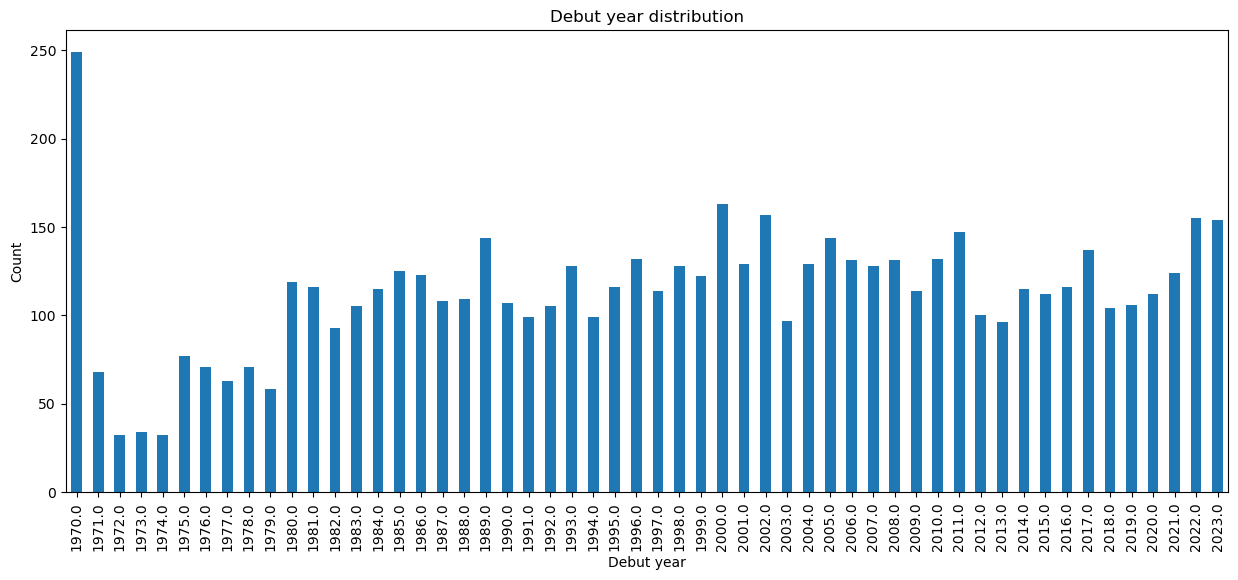

In [2]:
df3 = pd.read_csv(path.join('..','dataset', 'cyclists_final_enhanced.csv'))

plt.figure(figsize=(15, 6))
df3['debut_year'].value_counts().sort_index().plot(kind='bar')
plt.title('Debut year distribution')
plt.xlabel('Debut year')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In this case we can't find a noticeable pattern.

#### Most popular debut age

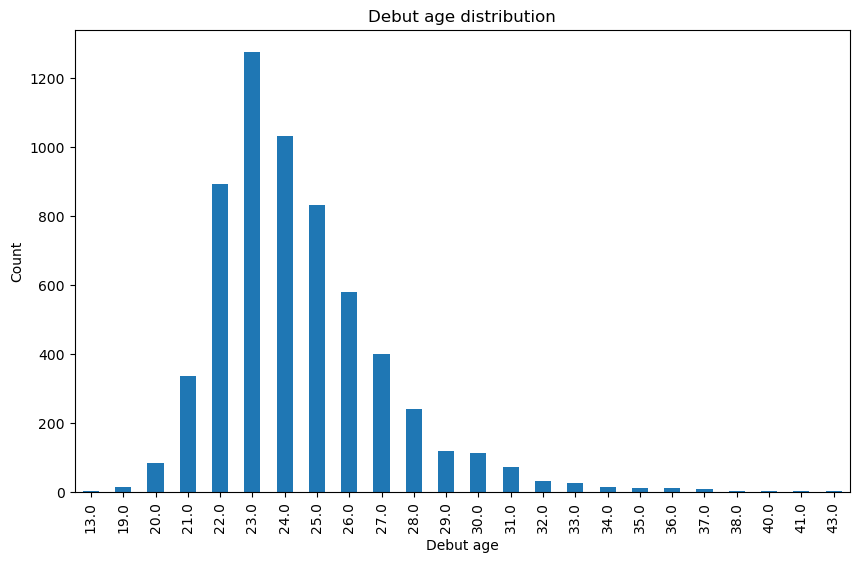

In [3]:
plt.figure(figsize=(10, 6))
df3['debut_age']=df3['debut_year']-df3['birth_year']

df3['debut_age'].value_counts().sort_index().plot(kind='bar')
df3.drop('debut_age', axis=1, inplace=True)
plt.title('Debut age distribution')

plt.xlabel('Debut age')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

#### Career duration distribution

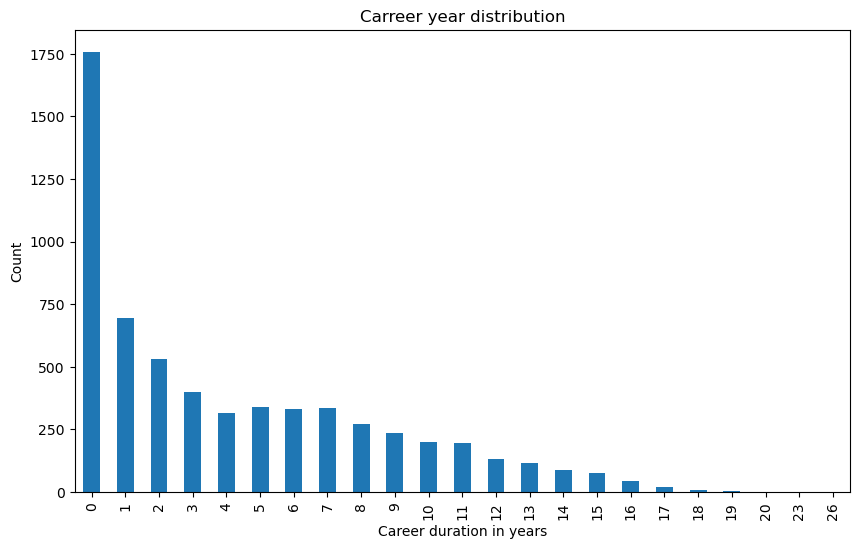

In [4]:
plt.figure(figsize=(10, 6))

df3['career_duration(years)']=df3['career_duration(days)']/365
df3['career_duration(years)']=df3['career_duration(years)'].astype(int)
df3['career_duration(years)'].value_counts().sort_index().plot(kind='bar')
df3.drop('career_duration(years)', axis=1, inplace=True)

plt.title('Carreer year distribution')

plt.xlabel('Career duration in years')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In this case the analysis shows that the most part of the cyclist have a short career of less then 1 year.

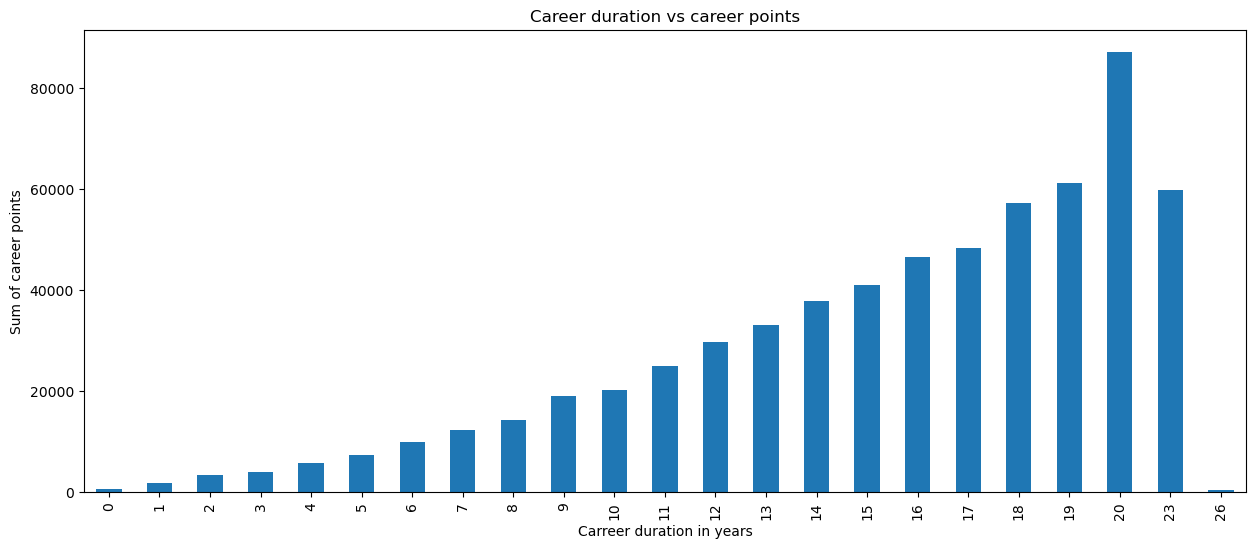

In [5]:
dfcarreeryears=df3.copy()
dfcarreeryears['career_duration(years)']=dfcarreeryears['career_duration(days)']/365
dfcarreeryears['career_duration(years)']=dfcarreeryears['career_duration(years)'].astype(int)

carreerduration = dfcarreeryears.groupby('career_duration(years)')['career_points'].mean()

plt.figure(figsize=(15, 6))
carreerduration.plot(kind='bar')

plt.title('Career duration vs career points')

plt.xlabel('Carreer duration in years')
plt.ylabel('Sum of career points')
plt.xticks(rotation=90)
plt.show()

In this case the correlation is evident, a longer career means a better career, in terms of general points.

#### BEST PERFORMANCE FOR BIRTH DATE 

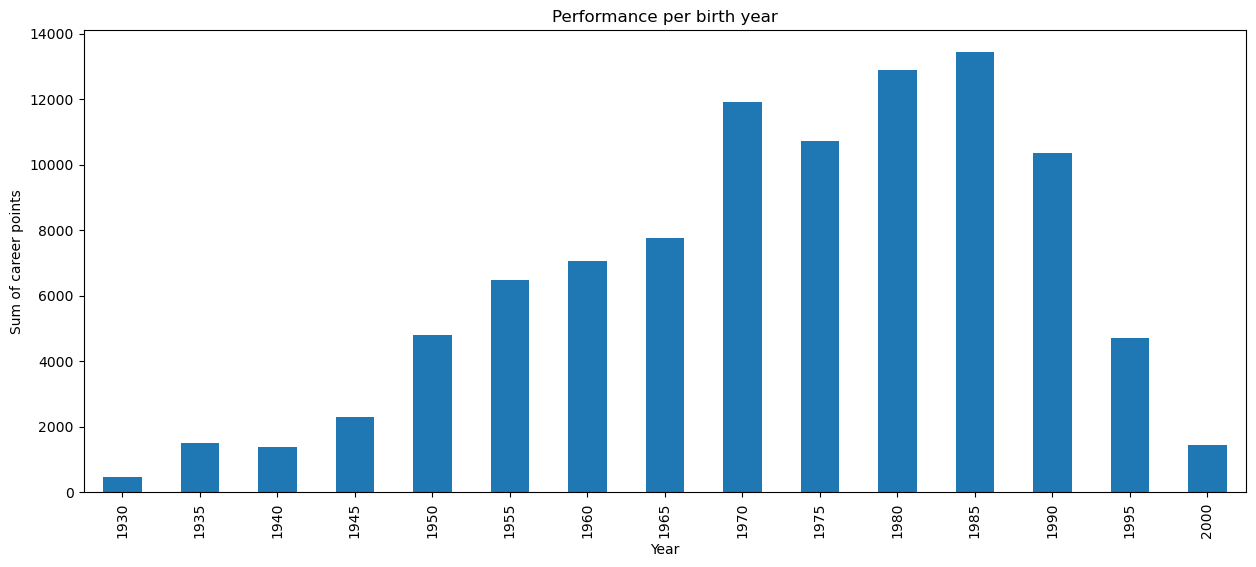

In [8]:
dfbinned=df3.copy()
dfbinned['birth_year']=dfbinned['birth_year']//5*5
performanceperyear = dfbinned.groupby('birth_year')['career_points'].mean()

plt.figure(figsize=(15, 6))
performanceperyear.plot(kind='bar')
#ADD BINNING FOR BETTER VISUALIZATION

plt.title('Performance per birth year')
plt.xlabel('Year')
plt.ylabel('Sum of career points')
plt.xticks(rotation=90)
plt.show()

#### PHISICAL FEATURES CORRELATION

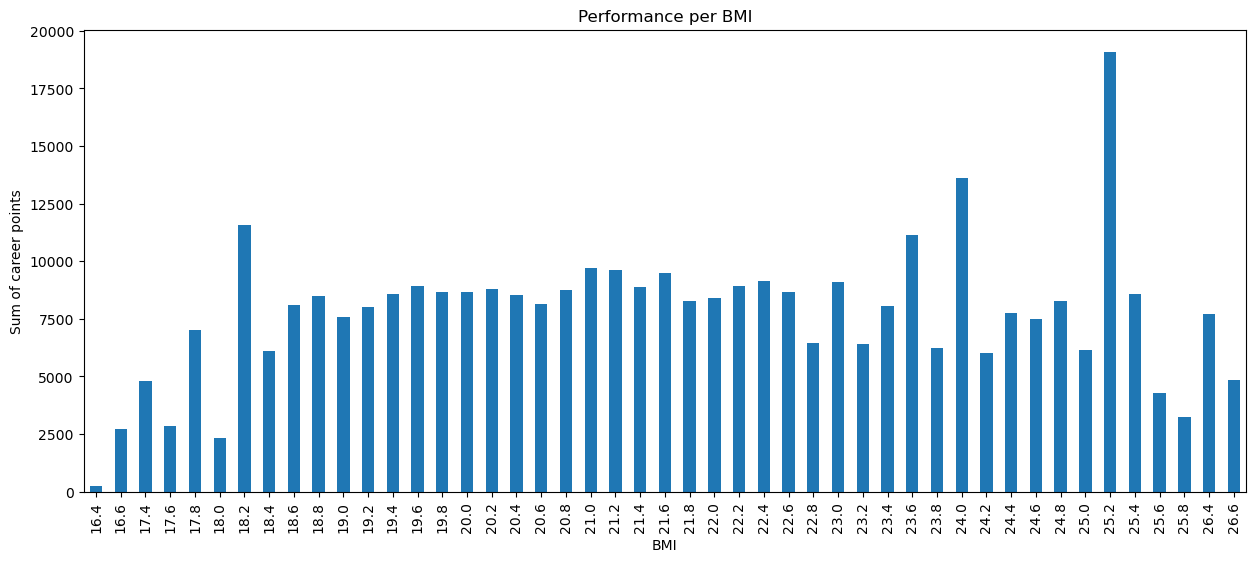

In [9]:
dfbmi=df3.copy()
dfbmi['bmi']=dfbmi['bmi']//0.2*0.2
dfbmi['bmi']=dfbmi['bmi'].round(1)
performanceperyear = dfbmi.groupby('bmi')['career_points'].mean()

plt.figure(figsize=(15, 6))
performanceperyear.plot(kind='bar')
#ADD BINNING FOR BETTER VISUALIZATION

plt.title('Performance per BMI')
plt.xlabel('BMI')
plt.ylabel('Sum of career points')
plt.xticks(rotation=90)
plt.show()

As we can easily see there is no evident correlation between these two features, but we can notise how 25.2 is the best bmi in relation to the recorded results

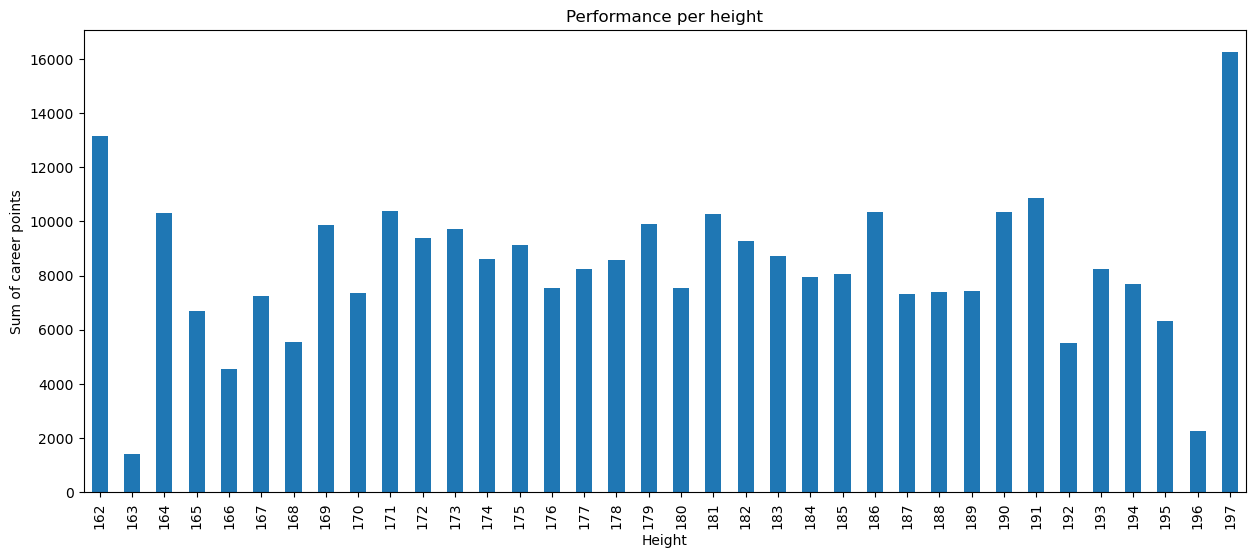

In [10]:

performanceperyear = df3.groupby('height')['career_points'].mean()

plt.figure(figsize=(15, 6))
performanceperyear.plot(kind='bar')
#ADD BINNING FOR BETTER VISUALIZATION

plt.title('Performance per height')
plt.xlabel('Height')
plt.ylabel('Sum of career points')
plt.xticks(rotation=90)
plt.show()

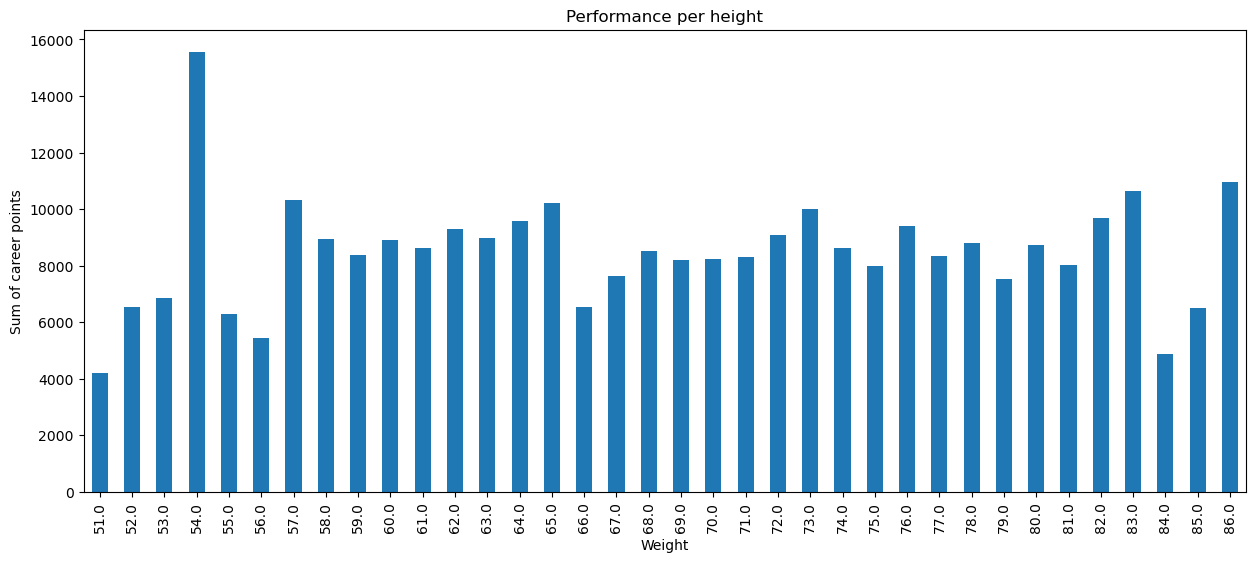

In [12]:
dfweight=df3.copy()
dfweight['weight']=dfweight['weight']//1
performanceperyear = dfweight.groupby('weight')['career_points'].mean()

plt.figure(figsize=(15, 6))
performanceperyear.plot(kind='bar')
#ADD BINNING FOR BETTER VISUALIZATION

plt.title('Performance per height')
plt.xlabel('Weight')
plt.ylabel('Sum of career points')
plt.xticks(rotation=90)
plt.show()

The phisical features correlation are pratically identical with really low correlation.
Now we can check the correlation between them, allegedly very high.

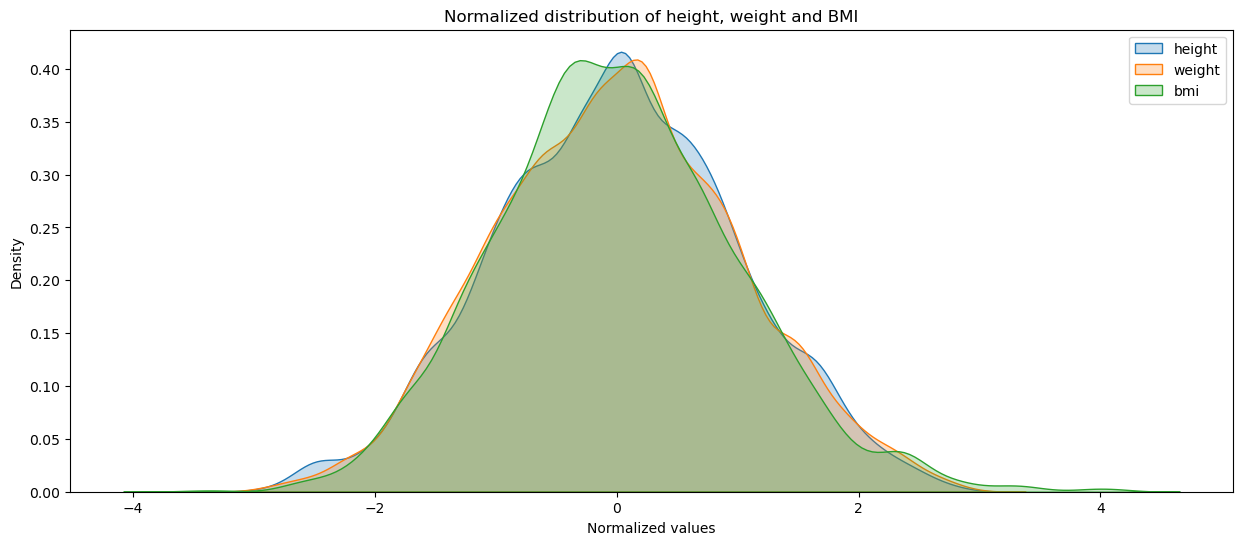

In [25]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
features = ['height', 'weight', 'bmi']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df3[features])
scaled_df = pd.DataFrame(scaled_data, columns=features)

for col in scaled_df.columns:
    sns.kdeplot(scaled_df[col], label=col, fill=True)

plt.title("Normalized distribution of height, weight and BMI")
plt.xlabel("Normalized values")
plt.legend()
plt.show()

Also from the superposition of the distributions it is obvious that this is very similar, having said that the sides of the curve are not very sharp so there is a high variety for these values. 

### CORRELATION BETWEEN VALUES

In [14]:
df3.head()

,_url,name,birth_year,weight,height,nationality,bmi,career_points,career_duration(days),career_duration(races),debut_year,avg_pos
0,bruno-surra,Bruno Surra,1964,73.0,185,Italy,21.329438,80.0,1.0,1.0,1989.0,110.000000
1,gerard-rue,Gérard Rué,1965,74.0,182,France,22.340297,26105.0,3492.0,222.0,1988.0,63.545045
2,jan-maas,Jan Maas,1996,69.0,189,Netherlands,19.316369,4425.0,519.0,49.0,2022.0,87.693878
3,nathan-van-hooydonck,Nathan Van Nathan Van Hooydonck,1995,78.0,192,Belgium,21.158854,17205.0,1982.0,161.0,2018.0,83.242236
4,jose-felix-parra,José Félix Parra,1997,55.0,171,Spain,18.809206,3085.0,721.0,48.0,2021.0,68.000000


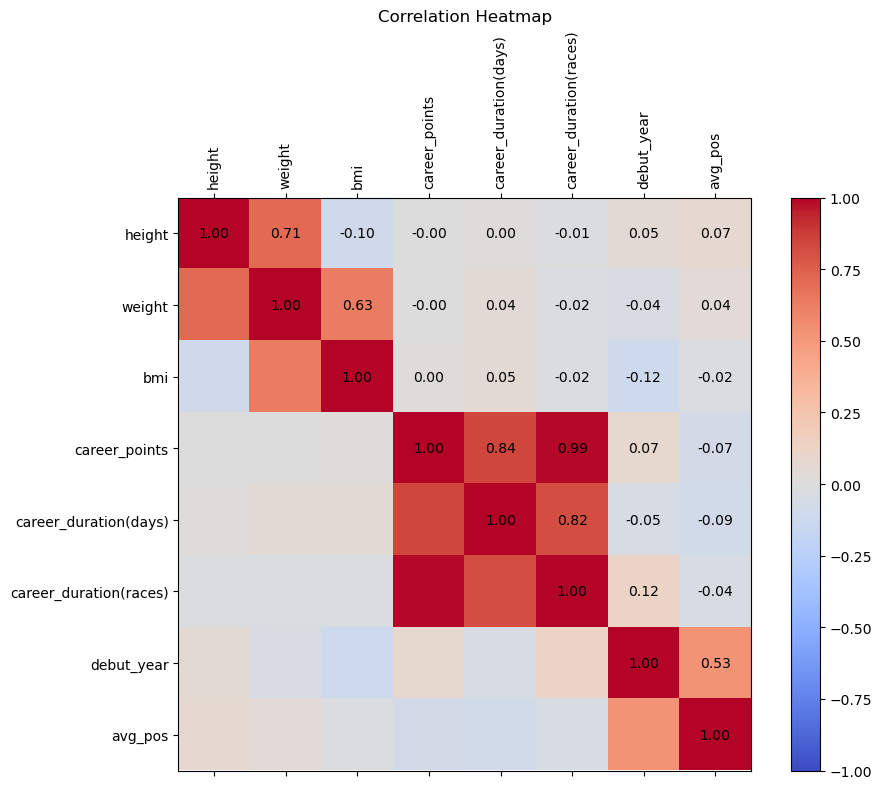

In [15]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



scaler = StandardScaler()
scaled_data = scaler.fit_transform(df3[['height', 'weight', 'bmi', 'career_points', 'career_duration(days)','career_duration(races)', 'debut_year', 'avg_pos']])
scaled_df = pd.DataFrame(scaled_data, columns=['height', 'weight', 'bmi', 'career_points', 'career_duration(days)','career_duration(races)', 'debut_year', 'avg_pos'])

correlation_matrix = scaled_df.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 8))

cax = ax.matshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)

fig.colorbar(cax)

ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=90)  # Etichette delle colonne
ax.set_yticklabels(correlation_matrix.columns)  # Etichette delle righe

for i in range(len(correlation_matrix.columns)):
    for j in range(i, len(correlation_matrix.columns)):  # Cambiato j da range(len) a range(i, len)
        ax.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black')

plt.title("Correlation Heatmap")

plt.tight_layout()

plt.show()

The first interesting factor to note is how bmi is correlated a great deal with weight and not at all with height, this can be justified by the fact that when fixing bmi to a correct value it is weight that is the only one that evidently can be varied. Also given the BMI formula (weight/height [m]^2) we see that the values of this in the calculation are almost irrelevant, reaching at most a divided 3 at initial weight. We have a high correlation with regard to physical values, as could be seen above. In addition we can see a high correlation between career days and career points, as we have been able to note in past analyses the higher scores are due to a sustained career.
An incredibly high correlation is the one between the number of races and career acumulated points, as we can see from the graph below this is almost linear. 

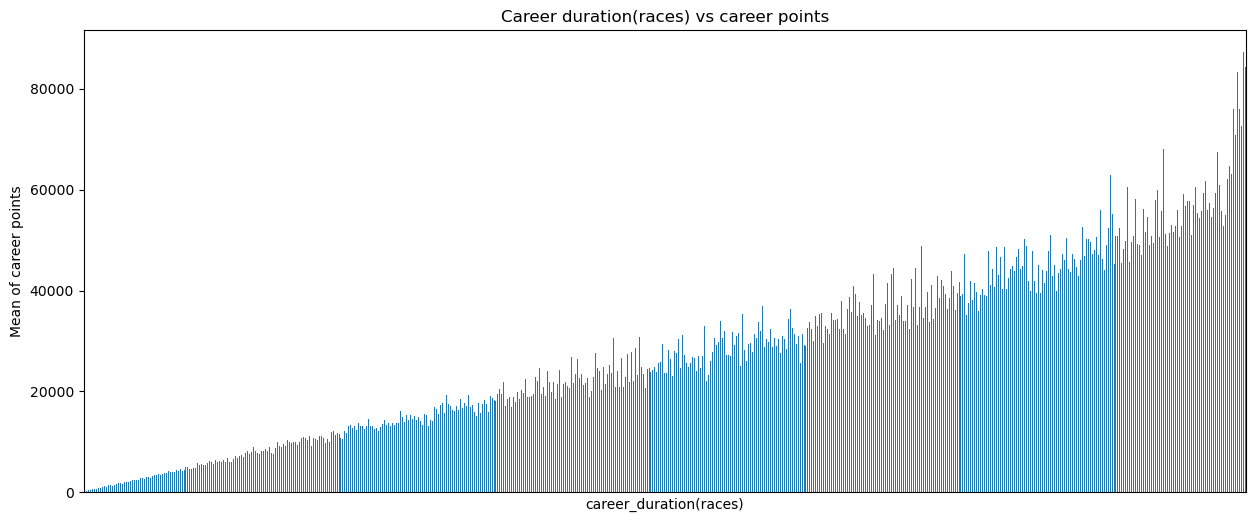

In [16]:
dfcarreeryears=df3.copy()
dfcarreeryears['career_duration(years)']=dfcarreeryears['career_duration(days)']/365
dfcarreeryears['career_duration(years)']=dfcarreeryears['career_duration(years)'].astype(int)

carreerduration = dfcarreeryears.groupby('career_duration(races)')['career_points'].mean()

plt.figure(figsize=(15, 6))
carreerduration.plot(kind='bar')

plt.title('Career duration(races) vs career points')

plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)

plt.ylabel('Mean of career points')
plt.xticks(rotation=90)
plt.show()